# Skin Cancer Classification with Grad-CAM
Train a CNN on the HAM10000 dataset using TensorFlow's Functional API and visualize model decisions using Grad-CAM.

In [ ]:
#ALSO RUN conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Install dependencies
%pip install kagglehub tensorflow opencv-python matplotlib scikit-learn pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Download the HAM10000 dataset using kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset downloaded to:", dataset_path)

c:\Users\rikta\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\rikta\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2


In [2]:
import os
# Load metadata
import pandas as pd
metadata = pd.read_csv(os.path.join(dataset_path, "HAM10000_metadata.csv"))
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
import tensorflow as tf
# Check if GPU is available

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✔ Memory growth enabled for GPU.")
    except RuntimeError as e:
        print("Failed to set memory growth:", e)

✔ Memory growth enabled for GPU.


In [4]:
# Map image_id to full paths from both image folders
import os

img_dir1 = os.path.join(dataset_path, "HAM10000_images_part_1")
img_dir2 = os.path.join(dataset_path, "HAM10000_images_part_2")

image_path_map = {}
for dir_path in [img_dir1, img_dir2]:
    for fname in os.listdir(dir_path):
        if fname.endswith(".jpg"):
            image_path_map[fname.split('.')[0]] = os.path.join(dir_path, fname)

metadata['image_path'] = metadata['image_id'].map(image_path_map)
metadata = metadata.dropna(subset=['image_path'])

In [7]:
# Preprocess images and labels
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

df = metadata[['image_path', 'dx']].copy()
df['dx'] = df['dx'].astype(str)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])  # Save le.classes_ for mapping back

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [8]:
# Build the CNN model using Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name="last_conv")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(7, activation='softmax', name='classifier')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0     

In [9]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10
251/251 [==============================] - 53s 187ms/step - loss: 0.6380 - accuracy: 0.8460 - val_loss: 4.2687 - val_accuracy: 0.0000e+00
Epoch 2/10
251/251 [==============================] - 41s 164ms/step - loss: 0.3425 - accuracy: 0.8847 - val_loss: 6.0975 - val_accuracy: 0.0729
Epoch 3/10
251/251 [==============================] - 42s 166ms/step - loss: 0.2790 - accuracy: 0.9024 - val_loss: 9.7076 - val_accuracy: 0.0025
Epoch 4/10
251/251 [==============================] - 39s 154ms/step - loss: 0.2483 - accuracy: 0.9161 - val_loss: 10.2768 - val_accuracy: 0.0080
Epoch 5/10
251/251 [==============================] - 38s 151ms/step - loss: 0.2027 - accuracy: 0.9290 - val_loss: 12.2007 - val_accuracy: 0.0090
Epoch 6/10
251/251 [==============================] - 41s 164ms/step - loss: 0.1602 - accuracy: 0.9448 - val_loss: 12.9090 - val_accuracy: 0.0255
Epoch 7/10
251/251 [==============================] - 40s 158ms/step - loss: 0.1405 - accuracy: 0.9554 - val_loss: 14.2235 

In [10]:
# Save the model
model.save("skin_cancer_model.h5")

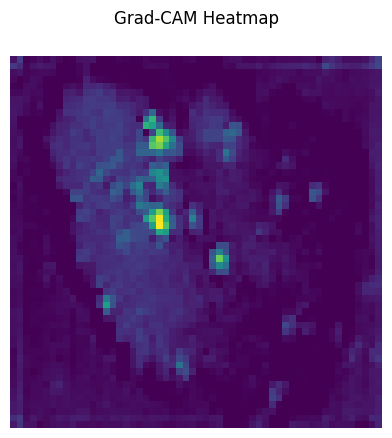

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="last_conv", pred_index=None):
    # Build a model that maps the input image to the activations + predictions
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the top predicted class with respect to the outputs of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map with the computed gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Get one batch from the validation generator
img_batch, label_batch = next(val_gen)  # (32, 224, 224, 3), (32, 7)

# Choose one image (e.g., index 0)
sample_image = img_batch[0:1]  # Keep batch dimension
sample_label = label_batch[0]

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(sample_image, model)

# Display the heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()
